In [1]:
import os
import pandas as pd
import pyodbc
import time
import numpy as np
import scipy.stats as stats
import itertools
from sqlalchemy import create_engine
from collections import Counter
import matplotlib.pyplot as plt

# Access Data

In [2]:
%load_ext sql

In [3]:
#ACCESS DATABASE

In [5]:
# SQL query
sql_query = ("SELECT cohort_definition_id, p.person_id, p.year_of_birth, cohort_start_date, " + 
       'cohort_end_date, c_race.concept_name as race, c_ethnicity.concept_name as ethnicity, ' + 
       'drug_exposure_start_date, drug_exposure_end_date, ' +
       'drug_type_concept_id, c_drugtype.concept_name as drug_type, ' + 
       'drug_concept_id, c_drug.concept_name as drug_name ' + 
        'FROM results.endocohorts '+
        'LEFT JOIN dbo.drug_exposure as de ON de.person_id = subject_id ' + 
        'LEFT JOIN dbo.person as p ON p.person_id = subject_id ' + 
        'LEFT JOIN dbo.concept as c_race ON c_race.concept_id = p.race_concept_id ' +
        'LEFT JOIN dbo.concept as c_ethnicity ON c_ethnicity.concept_id = p.ethnicity_concept_id ' +
        'LEFT JOIN dbo.concept as c_drugtype ON c_drugtype.concept_id = drug_type_concept_id ' +
        'LEFT JOIN dbo.concept as c_drug ON c_drug.concept_id = drug_concept_id ' + 
        'WHERE cohort_definition_id = 3;')
df = pd.read_sql(sql_query, engine)

# Prevalence Functions

In [6]:
# this function pulls all the codes for a given atc class 3 list
def generate_code_list(drugtype):
    sql_query = ("SELECT ancestor_concept_id, descendant_concept_id, concept_name " + 
               "FROM dbo.concept_ancestor JOIN dbo.concept ON descendant_concept_id = concept_id "+
               "WHERE ancestor_concept_id = (SELECT concept_id from dbo.concept WHERE concept_class_id = 'ATC 3rd' AND concept_name = '"+drugtype+"');")
    codes_list = pd.read_sql(sql_query, engine)
    return list(codes_list['descendant_concept_id'])

# this function calculates the relative prevalence of each drug type
def relative_drug_prev(list_codes, df):
    """
    1. This function subsets the dataframe to find only white and only Black patients who have been prescribed this drug
    2. It returns the relative prevalence (compared to overall patient prevalence) of 
        black and white patients who have been prescribed drugs within this class
    3. It looks at prevalence generally (overall), prior to diagnosis, and post-diagnosis 
        (where) the date of diagnosis is the cohort entry date
        
    https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_OpenIntro_Statistics_(Diez_et_al)./06%3A_Inference_for_Categorical_Data/6.02%3A_Difference_of_Two_Proportions
    """
    
    list_features = []
    df_subset = df.loc[df['drug_concept_id'].isin(list_codes)]
    df_subset_w = df_subset.loc[df['race'] == 'White']
    df_subset_b = df_subset.loc[df['race'] == 'Black or African American']


    # number of white/Black patients: 
    num_white_patients = len(df.loc[df['race'] == 'White']['person_id'].unique())
    num_black_patients = len(df.loc[df['race'] == 'Black or African American']['person_id'].unique())
    
    list_features.append(num_white_patients)
    list_features.append(num_black_patients)

    # Overall relative prevalence
    p1_white_overall = len(df_subset_w['person_id'].unique())/num_white_patients
    p2_black_overall = len(df_subset_b['person_id'].unique())/num_black_patients
    list_features.append(p1_white_overall)
    list_features.append(p2_black_overall)
   
    
    list_features.append(p1_white_overall-p2_black_overall)
    list_features.append(np.sqrt(p2_black_overall * (1 - p2_black_overall) / num_black_patients + p1_white_overall * (1 - p1_white_overall) / num_white_patients))
    
    return list_features

# TABLE 1: Descriptive Statistics 

### Descriptive Statistics Table: Endo Cohort 

In [7]:
# Get AGE
df['age'] = ((pd.to_datetime(df['cohort_start_date'])-pd.to_datetime(df['year_of_birth'], format='%Y')).astype('<m8[Y]')).astype('int64')
df['age'].value_counts().to_csv('age_counts.csv')
people_df = df[['person_id', 'age', 'race', 'ethnicity']].drop_duplicates()
age_dist = people_df['age'].value_counts()

# AGE: 15-21; 22-28; 29-35; 35-42; 42-49
age_15_21 = age_dist[(age_dist.index <= 21)].sum()
age_22_28 = age_dist[(age_dist.index > 21) & (age_dist.index<=28)].sum()
age_29_35 = age_dist[(age_dist.index > 28) & (age_dist.index<=35)].sum()
age_35_42 = age_dist[(age_dist.index > 35) & (age_dist.index<=42)].sum()
age_42_49 = age_dist[(age_dist.index > 42)].sum()

table1_ages = pd.DataFrame(data = [age_15_21, age_22_28, age_29_35, age_35_42, age_42_49], index = ['15-21', '22-28', '29-35', '35-42', '42-49'], columns = ['Endo Cohort (Counts)'])
table1_ages['Endo Cohort (%)'] = 100*table1_ages['Endo Cohort (Counts)']/sum(table1_ages['Endo Cohort (Counts)'])

In [8]:
# Get RACE
table1_race = pd.DataFrame(data=people_df['race'].value_counts().values, index = people_df['race'].value_counts().index, columns = ['Endo Cohort (Counts)'])
table1_race['Endo Cohort (%)'] = table1_race['Endo Cohort (Counts)']/sum(table1_race['Endo Cohort (Counts)'])

# Get ETHNICITY
table1_ethnicity = pd.DataFrame(data=people_df['ethnicity'].value_counts().values, index = people_df['ethnicity'].value_counts().index, columns = ['Endo Cohort (Counts)'])
table1_ethnicity['Endo Cohort (%)'] = table1_ethnicity['Endo Cohort (Counts)']/sum(table1_ethnicity['Endo Cohort (Counts)'])

### Descriptive Statistics Table: Comparison Cohort 

In [22]:
# Get AGE
age_dist_cc = pd.read_csv('apara_mdcd_age.csv', header = None).set_index(0)

# AGE: 15-21; 22-28; 29-35; 35-42; 42-49
age_15_21 = age_dist_cc[(age_dist_cc.index <= 21)][1].sum()
age_22_28 = age_dist_cc[(age_dist_cc.index > 21) & (age_dist_cc.index<=28)][1].sum()
age_29_35 = age_dist_cc[(age_dist_cc.index > 28) & (age_dist_cc.index<=35)][1].sum()
age_35_42 = age_dist_cc[(age_dist_cc.index > 35) & (age_dist_cc.index<=42)][1].sum()
age_42_49 = age_dist_cc[(age_dist_cc.index > 42)][1].sum()

table1_ages['Comparison Cohort (Counts)'] = [age_15_21, age_22_28, age_29_35, age_35_42, age_42_49]
table1_ages['Comparison Cohort (%)'] = 100*table1_ages['Comparison Cohort (Counts)']/sum(table1_ages['Comparison Cohort (Counts)'])
table1_ages

,Endo Cohort (Counts),Endo Cohort (%),Comparison Cohort (Counts),Comparison Cohort (%)
15-21,1616,9.870511,1233489,33.665975
22-28,3634,22.196433,755365,20.616397
29-35,5323,32.512827,671403,18.324798
35-42,3804,23.234791,499965,13.645690
42-49,1995,12.185439,503682,13.747140


In [10]:
# Get RACE
race_dist_cc = pd.read_csv('apara_mdcd_race.csv', header=None)
race_dist_cc.columns = ['Race', 'Comparison Cohort (Counts)']
race_dist_cc.set_index('Race', inplace=True)
table1_race = table1_race.merge(race_dist_cc, how = 'inner', left_index=True, right_index=True)
table1_race['Comparison Cohort (%)'] = table1_race['Comparison Cohort (Counts)']/sum(table1_race['Comparison Cohort (Counts)'])

# Get Ethnicity
ethnicity_dist_cc = pd.read_csv('apara_mdcd_ethnicity.csv', header=None)
ethnicity_dist_cc.columns = ['Ethnicity', 'Comparison Cohort (Counts)']
ethnicity_dist_cc.set_index('Ethnicity', inplace=True)
table1_ethnicity = table1_ethnicity.merge(ethnicity_dist_cc, how = 'inner', left_index=True, right_index=True)
table1_ethnicity['Comparison Cohort (%)'] = table1_ethnicity['Comparison Cohort (Counts)']/sum(table1_ethnicity['Comparison Cohort (Counts)'])

In [21]:
table1_race

,Endo Cohort (Counts),Endo Cohort (%),Comparison Cohort (Counts),Comparison Cohort (%)
White,10805,0.659968,1829312,0.499279
Black or African American,3814,0.232959,1199859,0.327481
No matching concept,1753,0.107073,634733,0.173240


In [11]:
table1_ethnicity

,Endo Cohort (Counts),Endo Cohort (%),Comparison Cohort (Counts),Comparison Cohort (%)
No matching concept,16108,0.983875,3525270,0.962162
Hispanic or Latino,264,0.016125,138634,0.037838


# Finding all drug classes for further analysis
significant-drugs-z-score.csv lists all ATC level 3 classes of drugs where there is a significant difference between the prescription prevalence for the endometriosis cohort and the comparison cohort. In this study, we limit ourselves to drug classes where the prescription prevalence is significantly higher in the endometriosis population.

In [12]:
significant_drug_differences = pd.read_csv('significant-drugs-z-score.csv')
significant_drugs = significant_drug_differences[significant_drug_differences['endo_mean_prev']>significant_drug_differences['comp_mean_prev']]
list_drugs = list(significant_drugs['concept_name'])
print(len(list_drugs))

28


# Find the relative prevalences overall, pre-diagnosis, and post-diagnosis
Use the function *relative_drug_prev* to find the relative prevalence of prescription for each drug class amongst Black and white patients. Then, we compare the mean difference between the prevalences using a 2-sided Z-test. This is repeated for 1. all prescriptions, 2. prescriptions prior to diagnosis, and 3. prescriptions post-diagnosis. 

In [13]:
# OVERALL
colnames = ['N_white', 'N_black', 'Prev_White_Overall', 'Prev_Black_Overall','Mean_Diff_Overall', 'SE_Overall']

df_prev_atc_endo = pd.DataFrame(columns = colnames)

for drugtype in list_drugs:
    list_codes = generate_code_list(drugtype)
    df_prev_atc_endo.loc[drugtype] = relative_drug_prev(list_codes, df)
    
df_prev_atc_endo['ZScore_Overall'] = df_prev_atc_endo['Mean_Diff_Overall']/df_prev_atc_endo['SE_Overall']
df_prev_atc_endo['p_val_overall'] = stats.norm.sf(np.abs(df_prev_atc_endo['ZScore_Overall']))

In [14]:
#PRE-DIAGNOSIS
colnames = ['N_white', 'N_black', 'Prev_White_Prior', 'Prev_Black_Prior','Mean_Diff_Prior', 'SE_Prior']

prev_prior = pd.DataFrame(columns = colnames)
df_prior = df.loc[pd.to_datetime(df['drug_exposure_start_date']) < pd.to_datetime(df['cohort_start_date'])]

for drugtype in list_drugs:
    list_codes = generate_code_list(drugtype)
    prev_prior.loc[drugtype] = relative_drug_prev(list_codes, df_prior)
    
prev_prior['ZScore_Prior'] = prev_prior['Mean_Diff_Prior']/prev_prior['SE_Prior']
prev_prior['p_val_prior'] = stats.norm.sf(np.abs(prev_prior['ZScore_Prior']))

In [15]:
#POST-DIAGNOSIS
colnames = ['N_white', 'N_black', 'Prev_White_Post', 'Prev_Black_Post','Mean_Diff_Post', 'SE_Post']

prev_post = pd.DataFrame(columns = colnames)
df_post = df.loc[pd.to_datetime(df['drug_exposure_start_date']) > pd.to_datetime(df['cohort_start_date'])]

for drugtype in list_drugs:
    list_codes = generate_code_list(drugtype)
    prev_post.loc[drugtype] = relative_drug_prev(list_codes, df_post)
    
prev_post['ZScore_Post'] = prev_post['Mean_Diff_Post']/prev_post['SE_Post']
prev_post['p_val_post'] = stats.norm.sf(np.abs(prev_post['ZScore_Post']))

# FIGURE 2: Difference in prevalence ± Standard error

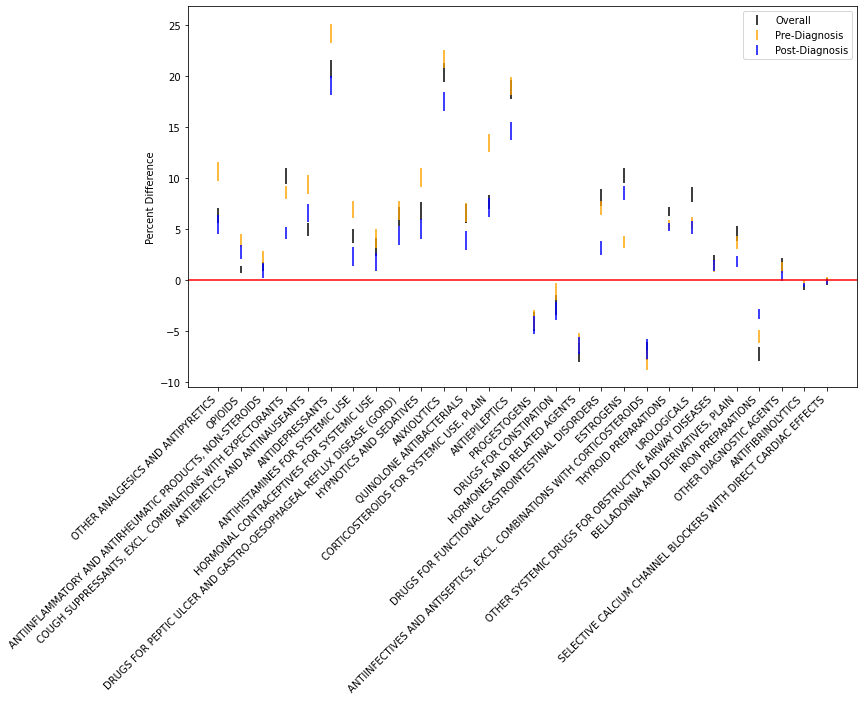

In [16]:
plt.figure(figsize=(12,7))
plt.errorbar(df_prev_atc_endo.index, df_prev_atc_endo['Mean_Diff_Overall']*100, yerr=df_prev_atc_endo['SE_Overall']*100, ls='none',color='k', label = 'Overall')
plt.errorbar(prev_prior.index, prev_prior['Mean_Diff_Prior']*100, yerr=prev_prior['SE_Prior']*100, ls='none',color='orange', label = 'Pre-Diagnosis')
plt.errorbar(prev_post.index, prev_post['Mean_Diff_Post']*100, yerr=prev_post['SE_Post']*100, ls='none',color='b', label = 'Post-Diagnosis')
plt.ylabel('Percent Difference')
plt.axhline(0, color='r')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

# TABLE 3: Comparing prevalence differences pre-diagnosis vs. post-diagnosis

In [23]:
diff_df = prev_prior[['Mean_Diff_Prior','SE_Prior', 'p_val_prior']]
diff_df = diff_df.merge(prev_post[['Mean_Diff_Post', 'SE_Post', 'p_val_post']], how='inner', left_index=True, right_index=True)
diff_df.loc[:,['Mean_Diff_Prior','SE_Prior','Mean_Diff_Post','SE_Post']] *= 100
diff_df.columns = ['Pre-Diagnosis: Mean Prevalence Difference (%)',
                   'Pre-Diagnosis: Standard Error (%)', 'Pre-Diagnosis: p-value',
                  'Post-Diagnosis: Mean Prevalence Difference (%)',
                   'Post-Diagnosis: Standard Error (%)', 'Post-Diagnosis: p-value']
diff_df.to_csv('diff_df.csv')
diff_df.head()

,Pre-Diagnosis: Mean Prevalence Difference (%),Pre-Diagnosis: Standard Error (%),Pre-Diagnosis: p-value,Post-Diagnosis: Mean Prevalence Difference (%),Post-Diagnosis: Standard Error (%),Post-Diagnosis: p-value
OTHER ANALGESICS AND ANTIPYRETICS,10.647111,0.898424,1.064687e-32,5.482770,0.926171,1.611432e-09
OPIOIDS,3.832236,0.641791,1.177847e-09,2.730506,0.668120,2.186331e-05
"ANTIINFLAMMATORY AND ANTIRHEUMATIC PRODUCTS, NON-STEROIDS",2.219864,0.658594,3.750102e-04,0.907683,0.760286,1.162644e-01
"COUGH SUPPRESSANTS, EXCL. COMBINATIONS WITH EXPECTORANTS",8.589266,0.649894,3.527165e-40,4.577783,0.604771,1.874006e-14
ANTIEMETICS AND ANTINAUSEANTS,9.366546,0.889384,3.092240e-26,6.543276,0.876276,4.097909e-14


# TABLE 4: Prescription prevalence differences for drug classes specific to endometriosis treatment
In this table, we list overall prevalence disparities for the endometriosis cohort and the comparison cohort. Due to the span of the comparison cohort, we only consider drugs classes referenced in the ESHRE clinical guidelines

In [18]:
cc_list_drugs = ['OTHER ANALGESICS AND ANTIPYRETICS', 'OPIOIDS','HORMONES AND RELATED AGENTS',
                 'HORMONAL CONTRACEPTIVES FOR SYSTEMIC USE', 'PROGESTOGENS', 'ESTROGENS']

atc_prev_cc = pd.read_csv('atc_prev_endo_cc.csv').set_index('Unnamed: 0')
atc_prev_cc['Z_score'] = atc_prev_cc['Mean_Diff_Overall']/atc_prev_cc['SE_Overall']
atc_prev_cc['p-val'] = (stats.norm.sf(np.abs(atc_prev_cc['Z_score'])))

In [19]:
table3 = atc_prev_cc.loc[cc_list_drugs][['Mean_Diff_Overall','SE_Overall','p-val']]
table3[['Mean_Diff_Overall','SE_Overall']]*=100
table3.columns = ['Comparison Cohort: Mean Prevalence Difference (%)',
                   'Comparison Cohort: Standard Error (%)', 'Comparison Cohort: p-value']
table3 = table3.merge(df_prev_atc_endo[['Mean_Diff_Overall','SE_Overall','p_val_overall']], how='inner', right_index=True, left_index=True)
table3.rename({'Mean_Diff_Overall': 'Endo Cohort: Mean Prevalence Difference (%)',
              'SE_Overall': 'Endo Cohort: Standard Error (%)',
              'p_val_overall': 'Endo Cohort: p-value'}, axis=1, inplace=True)
table3

,Comparison Cohort: Mean Prevalence Difference (%),Comparison Cohort: Standard Error (%),Comparison Cohort: p-value,Endo Cohort: Mean Prevalence Difference (%),Endo Cohort: Standard Error (%),Endo Cohort: p-value
OTHER ANALGESICS AND ANTIPYRETICS,-7.472038,0.057092,0.000000e+00,0.063556,0.007432,6.092425e-18
OPIOIDS,-4.933238,0.058172,0.000000e+00,0.010006,0.003379,1.530394e-03
HORMONES AND RELATED AGENTS,8.922818,0.048657,0.000000e+00,-0.071122,0.009398,1.903955e-14
HORMONAL CONTRACEPTIVES FOR SYSTEMIC USE,1.980721,0.058201,3.714238e-254,0.032612,0.008894,1.228274e-04
PROGESTOGENS,7.874307,0.051769,0.000000e+00,-0.040914,0.009345,5.987418e-06
ESTROGENS,-1.829559,0.024257,0.000000e+00,0.102352,0.007628,2.365233e-41


In [20]:
table3.to_csv('table3.csv')